In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime

### The Design

In [2]:
# One-sided Group Sequential Test with the parameters:
# looks=20
# alpha=0.05
# beta=0.2
# efficacy bounds <- sfPower(3)
# futility bounds <- sfPower(1.5)

# DO NOT change these parameters (the bounds depend on these specific inputs)
looks = 20
alpha = 0.05
beta = 0.2

efficacy_bounds = [4.368679592974322, 3.9169926294309585, 3.644672366875251, 3.437604393755575, 3.2658265452139026, 3.11666095740181, 2.983366415370115, 2.8618768462201127, 2.7494945347290263, 2.6443202974622584, 2.5449361771643972, 2.4502175752414415, 2.359204482138298, 2.2709817813403013, 2.1845458768102555, 2.098583569107613, 2.011019723398708, 1.9178406294426453, 1.80869446092883, 1.6336071755692716]
futility_bounds = [-2.251142692418225, -1.7555686234745964, -1.400894344789686, -1.1075512568318213, -0.8520613993323017, -0.6229236136572222, -0.4134185732171209, -0.21920574258413927, -0.03729169141150186, 0.1344925689854039, 0.2977817795116552, 0.45384765186978454, 0.603724155817457, 0.7482970222346029, 0.8884094796338858, 1.025029548167632, 1.1596100496017792, 1.29506338268711, 1.4394551357217893, 1.6336071755692716]
ppl = 0.056617268813894644

### Define Group Sequential Test

In [149]:
def run_sequential(data, column_names, control_name, kpi_type, base=None, N=None, MDrE=None, sigma=None, immature=False):
    """
    Run a group sequential test on experimental data.

    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing the experimental observations. Must include
        all columns referenced in `column_names`.

    column_names : dictionary
        Dictionary of column names required by the sequential test.
        All names must be strings and must exist in `data.columns`.

    control_name : str
        Name of the control group. Must exist in `data[column_names['group']]`.

    kpi_type : str
        Type of KPI. Accepted values:
        - "binary": KPI column is 0/1 (success/failure)
        - "continuous": KPI column is a real-valued metric
        No other values are allowed.

    base : float
        Baseline proportion or mean:
        - If kpi_type == "binary": expected conversion rate for the control group, between 0 and 1 (exclusive).
        - If kpi_type == "continuous": expected KPI for the control group.
        Must be a positive float.

    N : int, optional
        If specified, the *fixed* total sample size for each group (must be a positive integer).
        Exactly one of `N` and `MDrE` must be provided (the other must be None).

    MDrE : float, optional
        Minimum Detectable Relative Effect (as a decimal, e.g. 0.05).
        Must be > 0. Exactly one of `N` and `MDrE` must be provided (the other must be None).

    sigma : float
        Standard deviation of the KPI:
        - If kpi_type == "binary": can be set to None or ignored (binary variance is p*(1-p)).
        - If kpi_type == "continuous": must be > 0.
        Must be a positive float if provided.

    immature : bool
    Indicates whether enough time has passed since the last exposure
    to expect conversions in the data.
    - True:  Assume insufficient time has passed for some conversions.
    - False: Assume sufficient time for conversions has passed.

    Raises
    ------
    TypeError
        If any argument is of the wrong type.

    ValueError
        If any numeric argument is out of its required range or if column names are missing.
    """

    # --- Input validation ---

    # 1. Validate data
    if not isinstance(data, pd.DataFrame):
        raise TypeError(f"`data` must be a pandas DataFrame, got {type(data).__name__}")

    # 2. Validate column_names
    if not isinstance(column_names, dict):
        raise TypeError("`column_names` must be a dictionary")
    for key, col in column_names.items():
        if key != 'KPI_time':
            if col not in data.columns:
                raise ValueError(f"Column `{col}` for key `{key}` not found in DataFrame `data`")
        elif immature == True:
            if col not in data.columns:
                raise ValueError(f"Column `{col}` for key `{key}` not found in DataFrame `data`")

    # 3. Validate control_name
    if not isinstance(control_name, str):
        raise TypeError(f"`control_name` must be a string, got {type(control_name).__name__}")
    if control_name not in data[column_names['group']].unique():
        raise ValueError(f"`control_name` must be one of {data[column_names['group']].unique()}, got `{control_name}`")

    # 4. Validate kpi_type
    valid_kpis = {"binary", "continuous"}
    if not isinstance(kpi_type, str) or kpi_type.lower() not in valid_kpis:
        raise ValueError(f"`kpi_type` must be one of {valid_kpis}, got `{kpi_type}`")
    kpi_type = kpi_type.lower()

    # 5. Validate base
    if base is not None:
        if not isinstance(base, (int, float)):
            raise TypeError(f"`base` must be numeric, got {type(base).__name__}")
        if kpi_type == "binary" and not (0 < base < 1):
            raise ValueError(f"For binary KPI, `base` must be between 0 and 1 (exclusive), got {base}")

    # 6. Mutual exclusivity of N and MDrE
    if (N is None) == (MDrE is None):
        raise ValueError("Exactly one of `N` and `MDrE` must be provided (the other must be None)")

    # 7. Validate N
    if N is not None:
        if not isinstance(N, int):
            raise TypeError(f"`N` must be an integer, got {type(N).__name__}")
        if N <= 0:
            raise ValueError(f"`N` must be > 0, got {N}")

    # 8. Validate MDrE
    if MDrE is not None:
        if not isinstance(MDrE, (int, float)):
            raise TypeError(f"`MDrE` must be numeric, got {type(MDrE).__name__}")
        if MDrE <= 0:
            raise ValueError(f"`MDrE` must be > 0, got {MDrE}")

    # 9. Validate sigma
    if kpi_type == "continuous":
        if not isinstance(sigma, (int, float)):
            raise TypeError(f"For continuous KPI, `sigma` must be numeric, got {type(sigma).__name__}")
        if sigma <= 0:
            raise ValueError(f"For continuous KPI, `sigma` must be > 0, got {sigma}")

    # 10. Validate immature
    if not isinstance(immature, bool):
        raise TypeError(f"`immature` must be a boolean, got {type(immature).__name__}")

    # --- Run Test ---

    # Completing for N or MDrE
    if kpi_type == 'binary':
        sigma = np.sqrt(base * (1 - base))
    z_alpha = norm.ppf(1 - alpha)
    z_beta  = norm.ppf(1 - beta)
    if N is None:
        # Compute N
        MDaE = MDrE * base
        N = 2 * (sigma * (z_alpha + z_beta) / MDaE) ** 2
        N = int(np.ceil(N))
    else:
        # Compute MDrE
        MDaE = sigma * (z_alpha + z_beta) / np.sqrt(N / 2)
        MDrE = MDaE / base

    print(f'Minimum detectable relative effect: {MDrE:.2%}\n')
    print(f'Non‐sequential test N per arm: {N}')
    increment = int(ppl * N + 1)
    print(f'Group\'s size per look: {increment}\n')

    # Prepare the data
    df = data.copy()
    column_names_inv = {v: k for k, v in column_names.items()}
    df.rename(columns=column_names_inv, inplace=True)

    df['exposure_time'] = pd.to_datetime(df['exposure_time'])
    df.sort_values(by='exposure_time', inplace=True)

    if immature:
        df['KPI_time'] = pd.to_datetime(df['KPI_time'])
        df['KPI_time'] = df['KPI_time'].fillna(df['exposure_time'])

    df_control   = df[df['group'] == control_name].copy()
    df_treatment = df[df['group'] != control_name].copy()      # For now I assume only one treatment

    # Run test
    stats_sequence = []
    conclusion_reached = False
    for i in range(looks):

        current_size = (i+1) * increment
        if current_size > min(len(df_control), len(df_treatment)):
            print(f'**Data is sufficient for only {i} looks**\n')
            break

        if not immature:
            Y_control = df_control.iloc[:current_size]['KPI']
            Y_treatment = df_treatment.iloc[:current_size]['KPI']
        else:
            threshold_control = df_control.iloc[current_size-1]['exposure_time']
            threshold_treatment = df_treatment.iloc[current_size-1]['exposure_time']

            df_control['Adjusted_KPI'] = df_control['KPI'] * (df_control['KPI_time'] <= threshold_control)
            df_treatment['Adjusted_KPI'] = df_treatment['KPI'] * (df_treatment['KPI_time'] <= threshold_treatment)

            Y_control = df_control.iloc[:current_size]['Adjusted_KPI']
            Y_treatment = df_treatment.iloc[:current_size]['Adjusted_KPI']

        mean_control = Y_control.mean()
        mean_treatment = Y_treatment.mean()

        std_control = Y_control.std()
        std_treatment = Y_treatment.std()
        std_difference = np.sqrt((std_treatment**2 / current_size) + (std_control**2 / current_size))

        statistic = (mean_treatment - mean_control) / std_difference
        stats_sequence.append(statistic)

        if not conclusion_reached:
            if statistic > efficacy_bounds[i]:
                print(f'**Stop for efficacy after {i+1} looks** \n(Positive effect was demonstrated)\n')
                conclusion_reached = True
            elif statistic < futility_bounds[i]:
                print(f'**Stop for futility after {i+1} looks** \n(No sufficiently large positive effect was demonstrated)\n')
                conclusion_reached = True

    print(f'Mean KPI for control group: {mean_control:.4f}')
    print(f'Mean KPI for treatment group: {mean_treatment:.4f}')
    print(f'Observed relative lift: {mean_treatment / mean_control - 1:.2%}')

    # --- Plot Results ---
    plt.figure(figsize=(8, 4))

    x = np.arange(1, looks+1)
    plt.plot(x, efficacy_bounds, color='g', label='Efficacy')
    plt.plot(x, futility_bounds, color='r', label='Futility')
    plt.plot(x[:len(stats_sequence)], stats_sequence, color='b',
             marker='o', markersize=4, label='Statistic (with delay)')

    plt.axhline(y=0, color='k', linestyle='--', linewidth=0.7)

    ax = plt.gca()
    ymin = np.min(np.concatenate((futility_bounds, stats_sequence))) - 1
    ymax = np.max(np.concatenate((efficacy_bounds, stats_sequence))) + 1
    ax.fill_between(x, efficacy_bounds, ymax,
                    where=efficacy_bounds <= ymax,
                    color='green', alpha=0.1)
    ax.fill_between(x, ymin, futility_bounds,
                    where=futility_bounds >= ymin,
                    color='red', alpha=0.1)

    plt.title('Sequencial Test')
    plt.xlabel('Look')
    plt.ylabel('Statistic')
    plt.xticks(x)
    plt.xlim(1, looks)
    plt.ylim(ymin, ymax)
    plt.legend(loc='lower right')
    plt.show()

### Load the Data

In [31]:
data = pd.read_csv('/content/drive/MyDrive/Projects for Clients/2025-06 AutoDS/trustpilot population.csv')

### Run Group Sequential Test

Minimum detectable relative effect: 2.50%

Non‐sequential test N per arm: 46164
Group's size per look: 2614

**Stop for futility after 15 looks** 
(No sufficiently large positive effect was demonstrated)

Mean KPI for control group: 0.3082
Mean KPI for treatment group: 0.3109
Observed relative lift: 0.87%


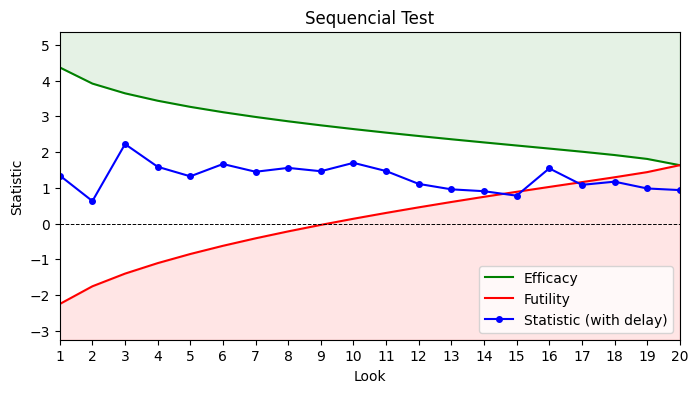

In [150]:
# Replace with the relevent column names
column_names = {'exposure_time': 'EXPOSURE_DATE',
                'group': 'VARIANT',
                'KPI': 'KPI_ACTION',
                'KPI_time': 'KPI_DATE'}

run_sequential(data=data,
               column_names=column_names,
               control_name='"Control"',
               kpi_type='binary',
               base=0.3,

               # Fill exactly one of these two:
               N=None,
               MDrE=0.025,

               # Fill if kpi_type == 'continuous'
               sigma=None,

               # Whether the data is immature
               immature=False)